# Notebook 1 - Data Download

## Install necessary packages to the class jupyterbook
* Only needs to be run once per server reset

In [ ]:
#!pip install pyPRISMClimate
#!pip install hydrofunctions

## Import required packages

In [1]:
# standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geospatial tools
import rasterio as rio
from rasterio import plot, mask
import geopandas as gpd
import xarray as xr

# file management tools
import glob
import os
import urllib

# data download tools
from pyPRISMClimate import get_prism_dailys
import hydrofunctions as hf

%matplotlib inline

## Get gauge data from USGS
* Download basin shapefile
* Download streamflow (or open it if it's previously been downloaded)
* Examine the data--plot the geometry and view the dataframe head to make sure it all looks good

In [2]:
# function to download usgs stream data, basin
def get_basin_data(gaugeID, start_date, end_date, sf_filepath, featureSource = 'nwissite'):
    basin_url = f'https://labs.waterdata.usgs.gov/api/nldi/linked-data/{featureSource}/USGS-{gaugeID}/basin'
    
    # get shapefile of gauge basin
    basin_gdf = gpd.read_file(basin_url)
    
    # get streamflow at gauge
    streamflow = hf.NWIS(site=gaugeID, service='dv', start_date=start_date, end_date=end_date, file=sf_filepath)
    streamflow_df = streamflow.df()
    return basin_gdf, streamflow_df

everson_gdf, everson_streamflow = get_basin_data(gaugeID = '12211200', start_date = '2021-11-10', end_date = '2021-12-10', sf_filepath = 'discharge_data/everson.parquet')

Reading data from discharge_data/everson.parquet


<Axes: >

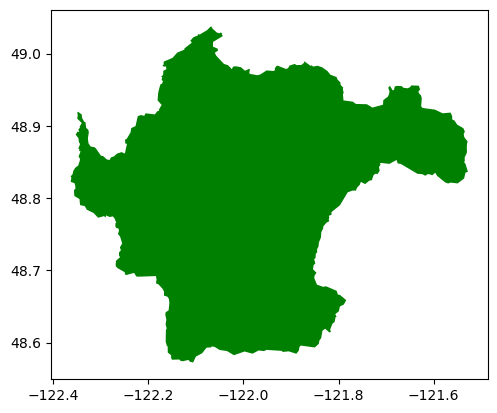

In [3]:
# plot to check it out, make sure it meets expectations
f, a = plt.subplots()
everson_gdf.plot(facecolor = 'green', ax=a)

In [4]:
everson_streamflow.head()

,USGS:12211200:00060:00003,USGS:12211200:00060:00003_qualifiers,USGS:12211200:00065:00003,USGS:12211200:00065:00003_qualifiers
datetimeUTC,,,,
2021-11-10 00:00:00+00:00,4850.0,A,75.21,A
2021-11-11 00:00:00+00:00,4520.0,A,75.03,A
2021-11-12 00:00:00+00:00,12500.0,A,78.27,A
2021-11-13 00:00:00+00:00,10900.0,A,77.84,A
2021-11-14 00:00:00+00:00,23000.0,A,81.07,A


## Download PRISM Data
* Current default variables are precipitation and mean temperature (for snow), but can be updated in function
* Uses gauge basin boundaries above to mask data
* Results in netcdf files for the variables as well as corresponding data arrays
* Preserves variable, date
* Plot the data arrays to make sure they look good

To do: 
* change return function to be more flexible in it's reference
* make a dictionary to update variable units?
* potentially reproject everything to be an equal-area-projection with meters as units instead of degrees

In [5]:
def get_weather_for_watershed(start_date, end_date, destination, boundaries, varlist = ['ppt', 'tmean']):
    # this function will help keep track of the variable being downloaded and the date
    def get_variable_and_date(filename):
        filename = filename.split('_')
        variable, date = filename[-5], pd.to_datetime(filename[-2])
        return variable, date
        
    # download prism data for each requested variable
    for var in varlist:
        files = get_prism_dailys(var, min_date = start_date, 
                                 max_date = end_date, dest_path = destination,
                                 keep_zip=False)
    
        # makes a list of the weather files downloaded by above
        prism_file_paths = glob.glob(os.path.join(destination, '*.bil'))
        prism_file_paths.sort()
    
        #empty list of datasets
        dss = []
    
        for file in prism_file_paths:
            # open file
            weather_file = rio.open(file)
        
            # mask file by watershed extent
            rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
            array, array_transform = rio.mask.mask(weather_file, everson_gdf.to_crs(weather_file.crs).geometry, 
                                               **rio_mask_kwargs)
        
            lon = []
            lat = []
        
            # transform pixel positions to latitude and longitude for xarray coordinates using the affine transform
            for i in range(array.shape[0]):
                x, y = rio.transform.xy(array_transform, i, 0)
                lon = np.append(lon, y)
        
            for j in range(array.shape[1]):
                x, y = rio.transform.xy(array_transform, 0, j)
                lat = np.append(lat, x)
        
            # use function to pull variable and date from filename
            variable, date = get_variable_and_date(file)
        
            # turn array into xarray to accomodate more dimensions
            ds = xr.Dataset({variable: (['lon', 'lat'], array)}, 
                                 coords = {'lon': lon, 'lat': lat})
        
            # add date dimension
            ds = ds.expand_dims(dim = 'date')
            ds.coords['date'] = ('date', [date])

            # add to full list of arrays
            dss.append(ds)
        
            # remove file (memory management), comment this line out if you'd like to preserve
            os.remove(file)
    
        # create single dataset of all datasets for variable
        globals()[f'ds_{variable}'] = xr.concat(dss, 'date')
        
        # download as a netcdf to open in other notebooks
        out_string = os.path.join(destination, f'{variable}_{start_date}-{end_date}.nc')
        globals()[f'ds_{variable}'].to_netcdf(path=out_string)
    
    # delete prism metadata files, they don't take up much space but there are a lot and they add clutter
    for filename in glob.glob(os.path.join(destination, "PRISM*")):
        os.remove(filename)
    return ds_ppt, ds_tmean

test_file_ppt, test_file_tmean = get_weather_for_watershed('2021-11-10', '2021-12-10', 'climate_data/', everson_gdf)

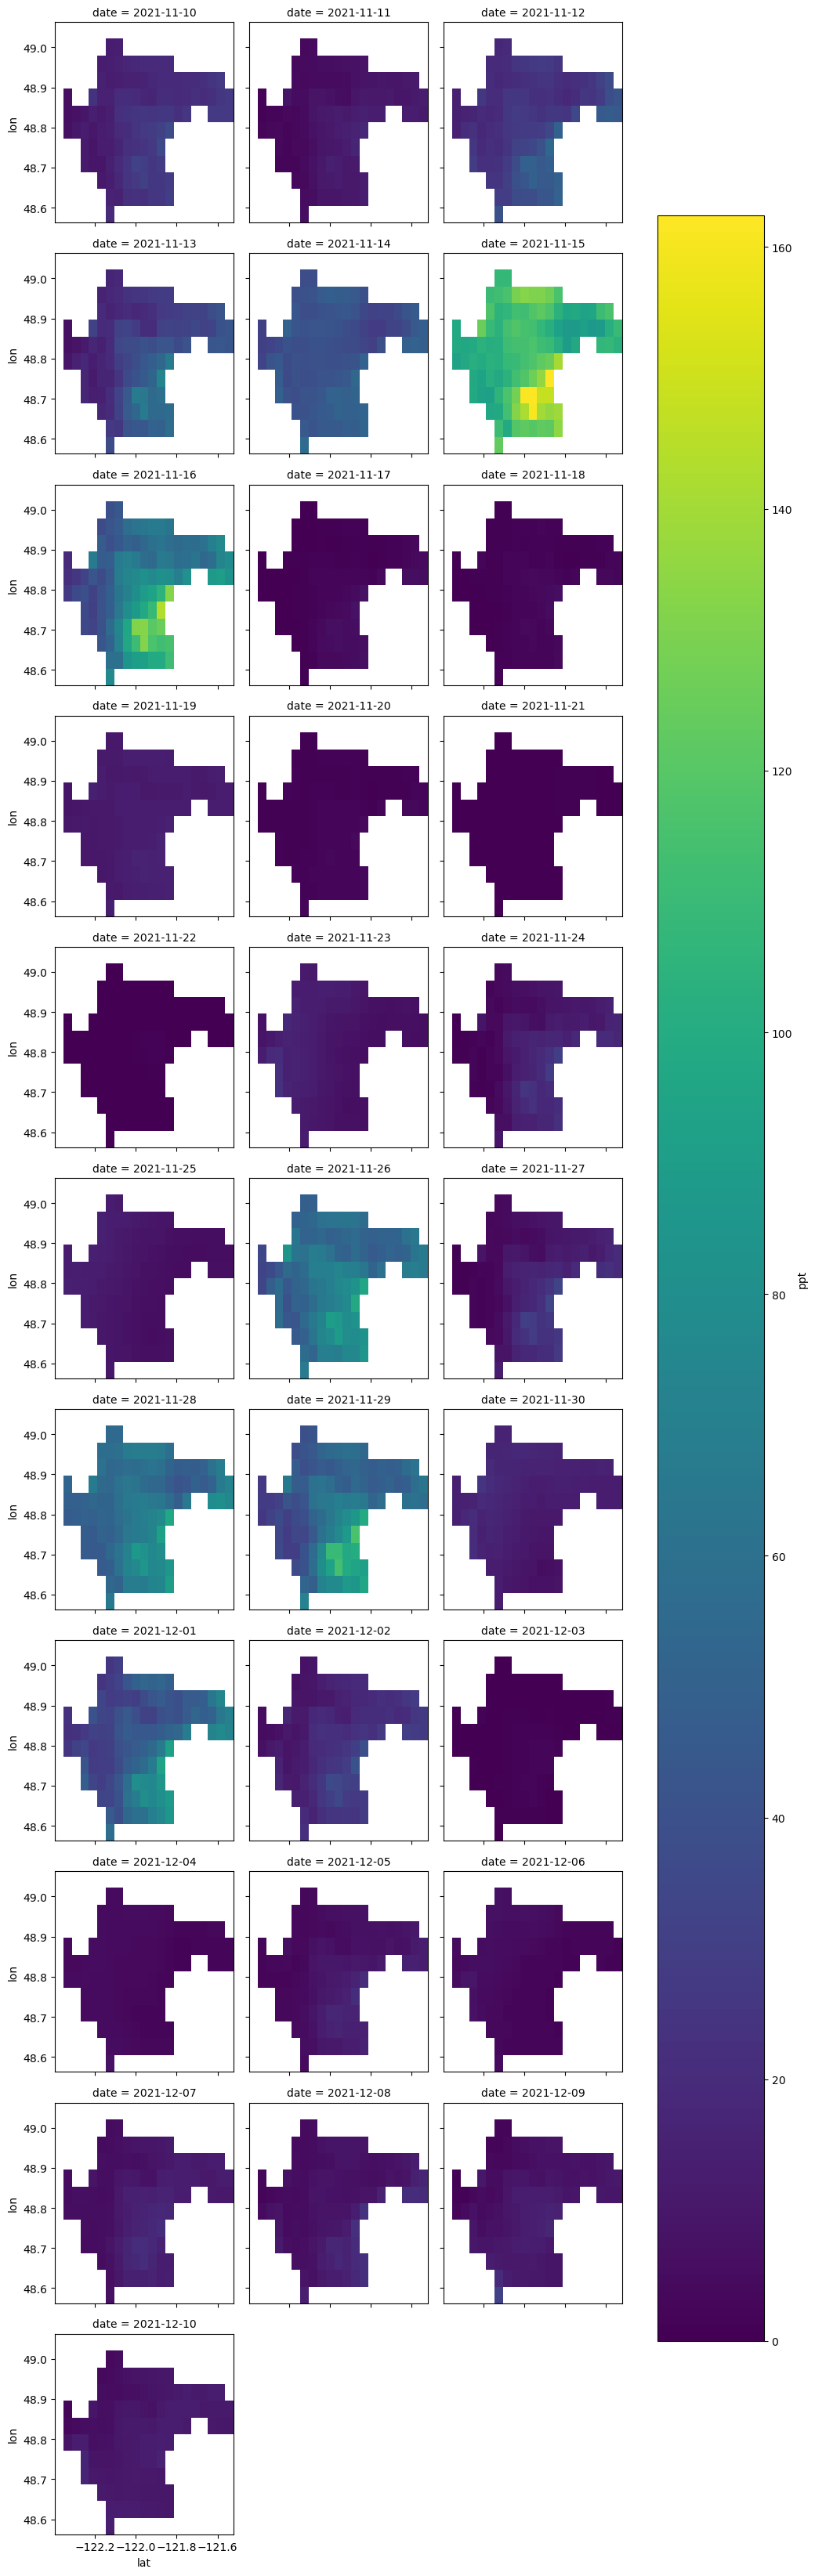

In [6]:
test_file_ppt['ppt'].isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 3)

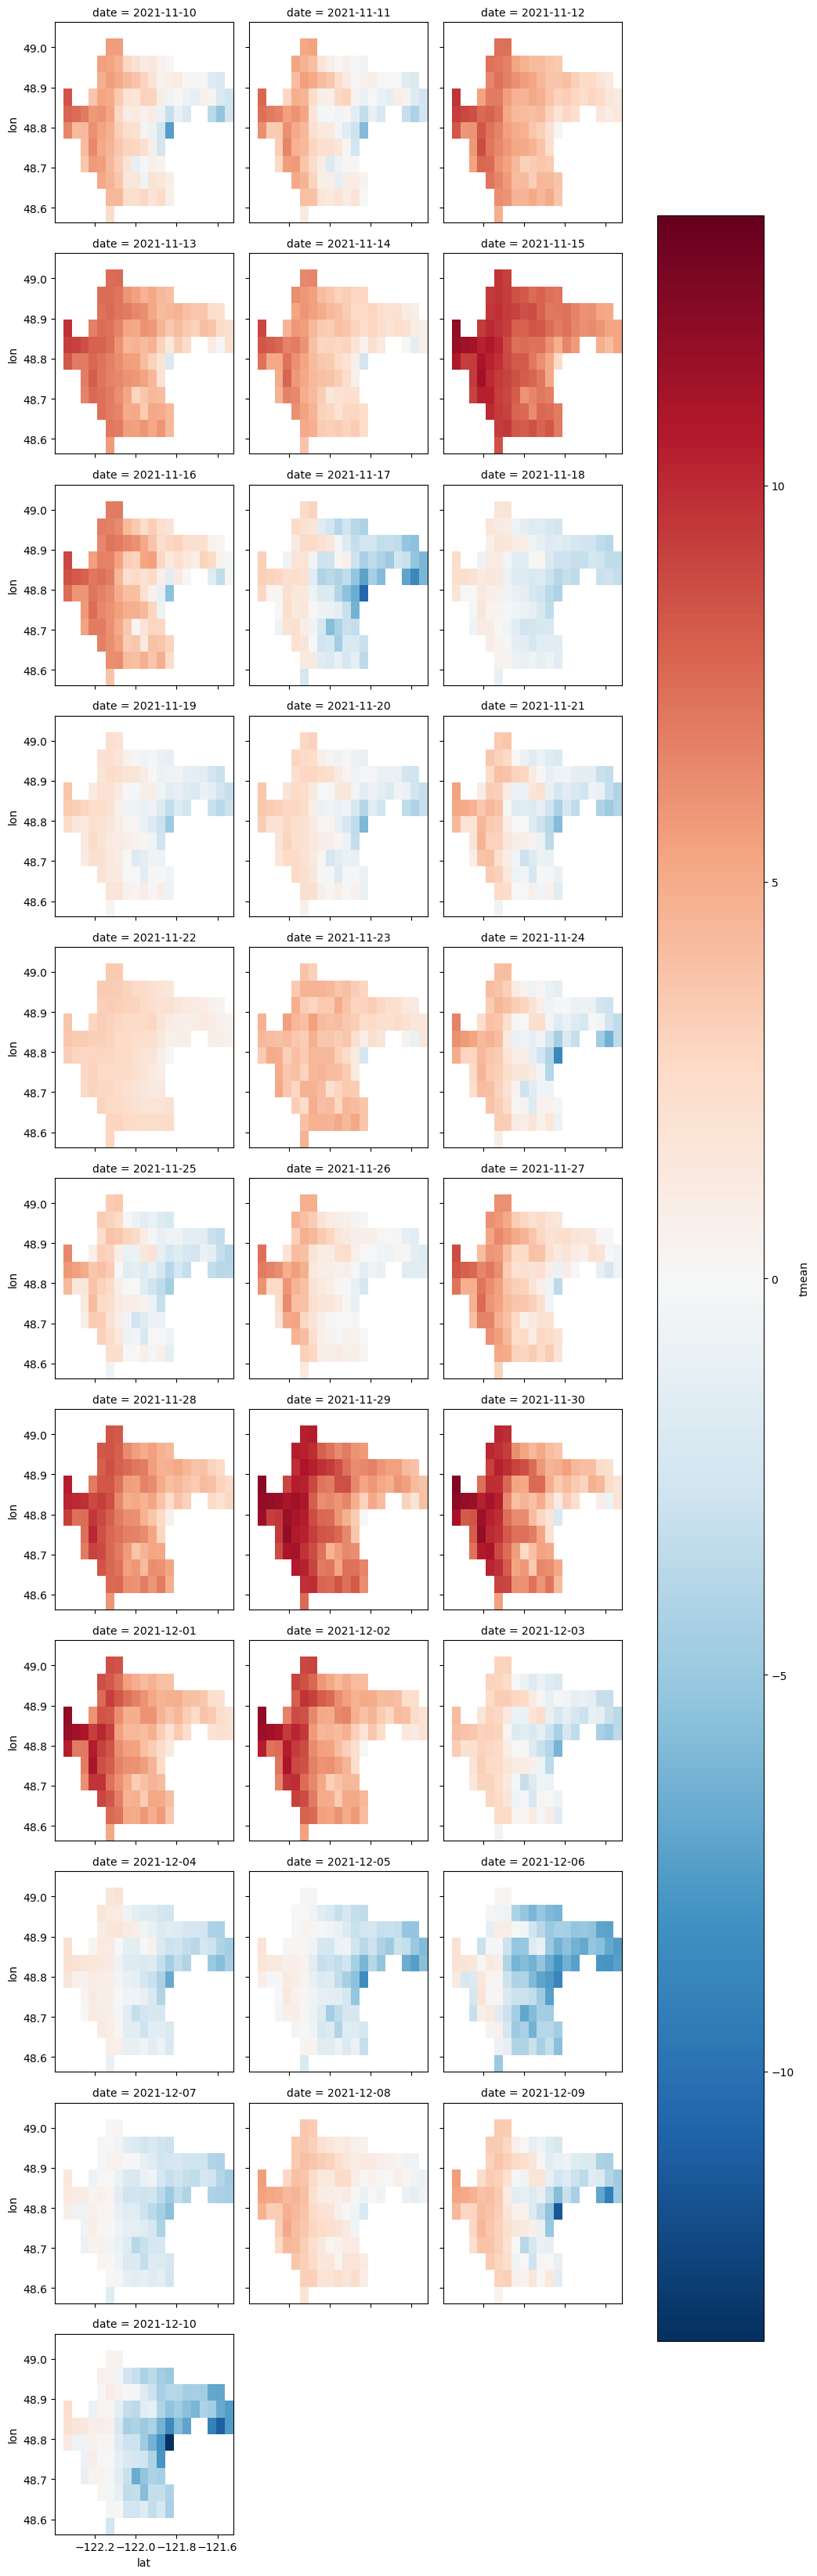

In [7]:
test_file_tmean['tmean'].isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 3)

## DEM stuff
To do:
* figure out if this stays in
* generate shapefile of boundaries to feed into above function?
* but for parameterization purposes needs to retain cell size

In [ ]:
# load dem
fork = 'nf'
in_asc_string = f'./dem_or_shapefile/final_{fork}_30m.asc'
out_gdal_string = f'./dem_or_shapefile/final_{fork}_30m.tif'
EPSG_code = 26710
dem_proj = f'EPSG:{EPSG_code}'

In [ ]:
dem_src = rio.open(out_gdal_string)
dem_array = dem_src.read(1)

In [ ]:
if not os.path.exists(out_gdal_string):
    !gdal_translate -of "GTiff" -a_srs EPSG:EPSG_code $in_asc_string $out_gdal_string

## SNOTEL Data
* For snow verification

In [ ]:
# get SNOTEL data
# ulmo!

## CO-OP Data
* for precipitation verification

In [ ]:
# get infiltration data - potentially could put it together via gSSURGO or land use files